In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:
# Data is saved in the same folder as the project. Then read data from tsv file
data = pd.read_csv("train-balanced-sarcasm.csv")
data.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


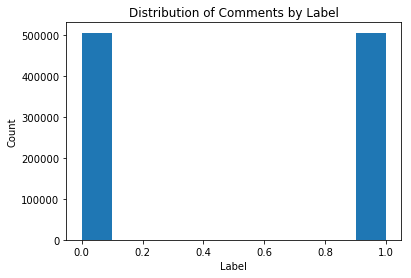

In [29]:
# Explore distribution of the data by label (0 -> non-sarcastic, 1 -> sarcastic)
plt.hist(data.label)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Comments by Label')
plt.show()

In [28]:
# Explore distribution of comments by label 
data.groupby('label').describe()

score                                                          ups  \
          count      mean        std    min  25%  50%  75%     max     count   
label                                                                          
0      505413.0  7.370436  55.991749 -298.0  1.0  2.0  4.0  5818.0  505413.0   
1      505413.0  6.400916  39.224064 -507.0  1.0  2.0  5.0  9070.0  505413.0   

                 ...                  downs                                \
           mean  ...  75%     max     count      mean       std  min  25%   
label            ...                                                        
0      5.775277  ...  3.0  5163.0  505413.0 -0.166175  0.372238 -1.0  0.0   
1      5.222493  ...  4.0  4010.0  505413.0 -0.125551  0.331343 -1.0  0.0   

                      
       50%  75%  max  
label                 
0      0.0  0.0  0.0  
1      0.0  0.0  0.0  

[2 rows x 24 columns]

KeyboardInterrupt: 

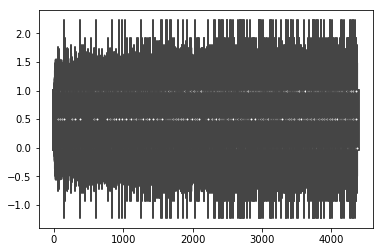